In [1]:
!pip install --upgrade pandas-profiling
!pip install --upgrade hypertools
!pip install --upgrade pandas

     |████████████████████████████████| 241 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 4.6 MB/s  eta 0:00:01
     |████████████████████████████████| 609 kB 9.2 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 16.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 43.0 MB/s eta 0:00:01


  Created wheel for tangled-up-in-unicode: filename=tangled_up_in_unicode-0.0.4-py3-none-any.whl size=1545721 sha256=9d015985372fe719f7c486be80fdce9e1cd99b1be46f83fcbb84de0a39469386
  Stored in directory: /root/.cache/pip/wheels/22/bb/74/1c79b7768407fd0acee5a61216474bd95b05ccdd38eac9c992
Successfully built tangled-up-in-unicode
ERROR: hypertools 0.6.2 has requirement scikit-learn<0.22,>=0.19.1, but you'll have scikit-learn 0.22.2.post1 which is incompatible.
ERROR: datalab 1.1.5 has requirement pandas-profiling==1.4.0, but you'll have pandas-profiling 2.6.0 which is incompatible.
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompatible.
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
  Attempting uninstall: phik
    Found existing installation: phik 0.9.8
    Uninstalling phik-0.9.8:
      Successfully uninstalled phik

ERROR: tpot 0.11.1 has requirement scikit-learn>=0.22.0, but you'll have scikit-learn 0.21.3 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.6.2 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement numpy<1.16,>=1.13, but you'll have numpy 1.18.1 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 0.21.3 which is incompatible.
ERROR: imbalanced-learn 0.6.2 has requirement scikit-learn>=0.22, but you'll have scikit-learn 0.21.3 which is incompatible.
ERROR: datalab 1.1.5 has requirement pandas-profiling==1.4.0, but you'll have pandas-profiling 2.6.0 which is incompatible.
ERROR: cesium 0.9.12 has requirement scikit-learn>=0.22.1, but you'll have scikit-learn 0.21.3 which is incompatible.
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompatible.
  Attempting uninstall: scikit-le

Download 

In [3]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [52]:
import os
import re
import logging

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from bs4 import BeautifulSoup

import tensorflow_hub as hub
import tensorflow as tf
import tokenization
from nltk import tokenize
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint

Check if we can use GPU

In [6]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11424292157141021795,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17127818414662994177
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15870492672
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4176209840813388608
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12732642497079708933
 physical_device_desc: "device: XLA_GPU device"]

In [ ]:
import keras.backend.tensorflow_backend as tfback
def _get_available_gpus():  

    if tfback._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        tfback._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]


tfback._get_available_gpus = _get_available_gpus

In [14]:
for local_device in device_lib.list_local_devices():
    if local_device.device_type == "GPU":
        K.tensorflow_backend._get_available_gpus()
        print("GPU available.")
        break
else:
    print("GPU is not available.")

GPU available.


In [15]:
base_path = "/kaggle"

# Chech if its in kaggle environment 
if os.path.exists(base_path):
    input_path = os.path.join(base_path, "input", "nlp-getting-started")
    output_path = os.path.join(base_path, "working")
else:
    base_path = "data"
    input_path = base_path
    output_path = os.path.join(base_path, "submissions")


train_file = os.path.join(input_path, "train.csv")
test_file = os.path.join(input_path, "test.csv")

In [16]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Data Cleaning

In [78]:
def clean_html_encoding(text):
    text = BeautifulSoup(text, 'lxml').get_text()
    return text


def remove_html_tags(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)


def remove_urls(text):
    links_reg = re.compile(r'https?://[A-Za-z0-9./]+')
    return links_reg.sub(r'', text)


def remove_mentions(text):
    mentions_reg = re.compile(r'@[A-Za-z0-9]+')
    return mentions_reg.sub(r'', text)

def remove_hashtags(text):
    mentions_reg = re.compile(r'#')
    return mentions_reg.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_puntuation(tokens):
    return [token for token in tokens if token.isalpha()]

def clean_chars_and_contracts(tweet):
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   

    return tweet

def clean_text(text):
    text = clean_html_encoding(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_emoji(text)
    text = remove_hashtags(text)
    
    text = " ".join([word.lower() for word in text.split()])
    text = clean_chars_and_contracts(text)
    
    tokens = tokenize.word_tokenize(text)

    return " ".join(tokens)

In [79]:
train_df.loc[:, "text_cleaned"] = train_df.text.apply(clean_text)
test_df.loc[:, "text_cleaned"] = test_df.text.apply(clean_text)

### BERT

Download BERT layer from TensorFlow Hub

In [22]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

In [23]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

Encode tweets

In [24]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[: max_len - 2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [25]:
sample_tweets = train_df.sample(n=2)["text_cleaned"].values

for tweet in sample_tweets:
    tokens, masks, segments = bert_encode(tweet, tokenizer, 160)
    
    print(f"Original tweet: {tweet}")
    print(f"Tokens: {tokens}\nMasks: {masks}\nSegments: {segments}")
    print("-"*25)

Original tweet: # ccot # tcot # radiation nuclear emergency tracking center
Tokens: [[ 101 1001  102 ...    0    0    0]
 [ 101  102    0 ...    0    0    0]
 [ 101 1039  102 ...    0    0    0]
 ...
 [ 101 1056  102 ...    0    0    0]
 [ 101 1041  102 ...    0    0    0]
 [ 101 1054  102 ...    0    0    0]]
Masks: [[1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
Segments: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
-------------------------
Original tweet: wackos like # michelebachman predict the world will soon be obliterated by a burning firey inferno but cant accept # globalwarming ! ! hello ! ! !
Tokens: [[ 101 1059  102 ...    0    0    0]
 [ 101 1037  102 ...    0    0    0]
 [ 101 1039  102 ...    0    0    0]
 ...
 [ 101  999  102 ...    0    0    0]
 [ 101  102    0 ...    0    0    0]
 [ 101  999  102 ...    0    0    0]]
Masks:

#### Tokenize train and test

In [32]:
train_input = bert_encode(train_df.text_cleaned.values, tokenizer, max_len=160)
train_labels = train_df.target.values

Model architecture

In [53]:
def build_model(max_len=160):
    # Input
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
def plot_history(history, k):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title(f'Fold {k}: Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title(f'Fold {k}: Training and validation loss')
    plt.legend()

### Train model

Fold 1
Train size for class 0: 2171 - 1: 1635 Total: 3806
Test size for class 0: 2171 - 1: 1636 Total: 3807
Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0]

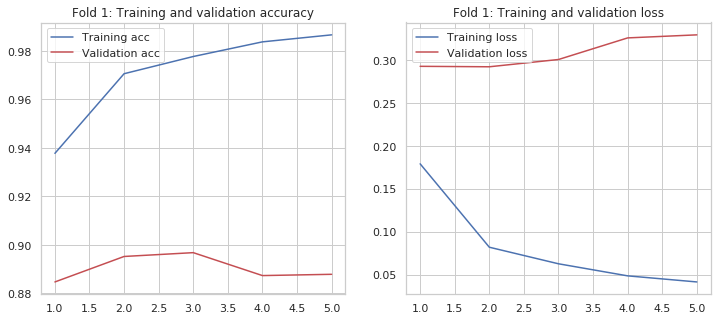

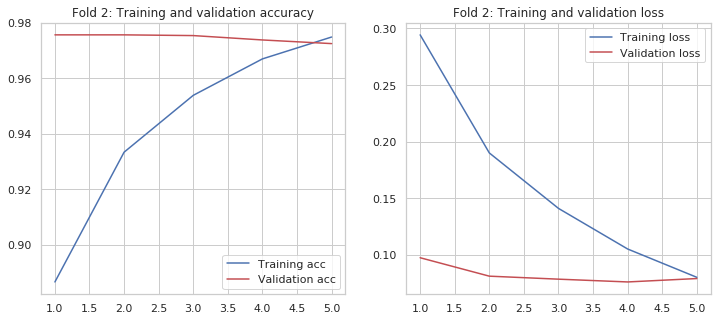

In [110]:
models = []

skf = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)
for fold, (train, test) in enumerate(skf.split(train_df, train_df["target"]), start=1):
    print(f"Fold {fold}")
    x_train, y_train = train_df.loc[train, "text_cleaned"], train_df.loc[train, "target"]
    x_test, y_test = train_df.loc[test, "text_cleaned"], train_df.loc[test, "target"]
    
    train_samples_per_class = y_train.value_counts()
    test_samples_per_class = y_test.value_counts()
    print(f"Train size for class 0: {train_samples_per_class[0]} - 1: {train_samples_per_class[1]} Total: {train_samples_per_class.sum()}")
    print(f"Test size for class 0: {test_samples_per_class[0]} - 1: {test_samples_per_class[1]} Total: {test_samples_per_class.sum()}")
    
    # Encode tweets
    train_input = bert_encode(x_train, tokenizer, max_len=160)
    test_input = bert_encode(x_test, tokenizer, max_len=160)
    
    # Build and train model
    model = build_model()
    history = model.fit(train_input, 
                        y_train, 
                        validation_data=(test_input, y_test), 
                        epochs=5, 
                        batch_size=32)
    
    models.append(model)
    
    
    # Evaluation
    plot_history(history, fold)

In [35]:
# history = model.fit(
#     train_input, train_labels,
#     validation_split=0.2,
#     epochs=5,
#     batch_size=32
# )

Train on 6090 samples, validate on 1523 samples
Epoch 1/5
6090/6090 [==============================] - 145s 24ms/sample - loss: 0.4144 - accuracy: 0.8213 - val_loss: 0.3918 - val_accuracy: 0.8345
Epoch 2/5
6090/6090 [==============================] - 133s 22ms/sample - loss: 0.3151 - accuracy: 0.8695 - val_loss: 0.3928 - val_accuracy: 0.8385
Epoch 3/5
6090/6090 [==============================] - 133s 22ms/sample - loss: 0.2556 - accuracy: 0.9005 - val_loss: 0.4187 - val_accuracy: 0.8273
Epoch 4/5
6090/6090 [==============================] - 133s 22ms/sample - loss: 0.2019 - accuracy: 0.9264 - val_loss: 0.4286 - val_accuracy: 0.8306
Epoch 5/5
6090/6090 [==============================] - 133s 22ms/sample - loss: 0.1486 - accuracy: 0.9460 - val_loss: 0.4685 - val_accuracy: 0.8293


In [50]:
model.save("bert_disaster_tweets.h5")

### Prediction and submission

In [112]:
test_input = bert_encode(test_df.text_cleaned.values, tokenizer, max_len=160)

In [118]:
y_pred = model.predict(test_input[:3])
print(y_pred)
y_pred.round().astype(int)

[[0.98904675]
 [0.8224825 ]
 [0.9966487 ]
 ...
 [0.996624  ]
 [0.99102986]
 [0.9973054 ]]


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [122]:
predictions_dict = dict()
for i, model in enumerate(models, start=1):
    # y_pred = model.predict(test_input).round().astype(int)
    predictions_dict[i] = model.predict(test_input).round().astype(int).flatten()
    
    print(f"Model {i} prediction done!")
    
predictions_df = pd.DataFrame(predictions_dict)

Model 1 prediction done!
Model 2 prediction done!


In [138]:
predictions_df["diff"] = predictions_df[1] - predictions_df[2]

predictions_df[predictions_df != 0.0]

SyntaxError: invalid syntax (<ipython-input-138-4846663c318e>, line 1)

Prediction using Majority Voting 

In [132]:
predictions = predictions_df.mean(axis=1).astype(int)

In [133]:
def create_submission_file(predictions, ids, path, filename="submission.csv"):
    submission_data = {
        "id": ids,
        "target": predictions
    }

    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(os.path.join(path, filename), index=False)
    
    print("Good luck!")

In [135]:
create_submission_file(predictions, test_df.id, output_path, filename="submission_bert_mv.csv")

Good luck!
